# Experiment 10 - Implementing Non Parametric Locally Weighted Regression on Non-linear Data

## Theory

### Parametric vs Non-Parametric Learning Algorithms
Parametric — In a Parametric Algorithm, we have a fixed set of parameters such as theta that we try to find(the optimal value) while training the data. After we have found the optimal values for these parameters, we can put the data aside or erase it from the computer and just use the model with parameters to make predictions. Remember, the model is just a function.

Non-Parametric — In a Non-Parametric Algorithm, you always have to keep the data and the parameters in your computer memory to make predictions. And that’s why this type of algorithm may not be great if you have a really really massive dataset.

### Need for NPLW Regression
We specifically apply this regression technique when the data to fit is non-linear. In Linear Regression we would fit a straight line to this data but that won’t work here because the data is non-linear and our predictions would end up having large errors. We need to fit a curved line so that our error is minimized.

### How NPLW Regression Works
In Locally weighted linear regression, we give the model the `x` where we want to make the prediction, then the model gives all the `x(i)`’s around that `x` a higher weight close to one, and the rest of `x(i)`’s get a lower weight close to zero and then tries to fit a straight line to that weighted `x(i)`’s data.

This means that if want to make a prediction for the green point on the x-axis (see figure below), the model gives higher weight to the input data i.e. `x(i)`’s near or around the circle above the green point and all else `x(i)` get a weight close to zero, which results in the model fitting a straight line only to the data which is near or close to the circle. The same goes for the purple, yellow, and grey points on the x-axis.

![](./assets/NPLWR-graph.webp)

### Important Formulae
In Linear regression, we had the following loss function 

![](./assets/linear-regression-loss-function.webp)

The modified loss for locally weighted regression 

![](./assets/modified-loss-function.webp)

`w(i)` (the weight for the ith training example) is the only modification.

where the weighting function is, 

![](./assets/weighting-function.webp)

`x` is the point where we want to make the prediction. `x(i)` is the `ith` training example.

The value of this function is always between 0 and 1.

So, if we look at the function, we see that

    If |x(i)-x| is small, w(i) is close to 1.
    If |x(i)-x| is large, w(i) is close to 0.

The `x(i)`’s which are far from `x` get `w(i)` close to zero and the ones which are close to `x`, get `w(i)` close to 1.

### Calculating Error
In the loss function, it translates to error terms for the `x(i)`’s which are far from `x` being multiplied by almost zero and for the `x(i)`’s which are close to `x` get multiplied by almost 1. In short, it only sums over the error terms for the `x(i)`’s which are close to `x`.

### Algorithm
Actually, there exists a closed-form solution for this algorithm which means that we do not have to train the model, we can directly calculate the parameter theta using the following formula.

![](./assets/closed-form-solution-for-theta.webp)

# Code

## Importing Libraries

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

%matplotlib inline

warnings.filterwarnings('ignore')

## Generating Non-linear Data
A good way to create a non-linear dataset is to mix sines with different phases. The dataset we will work with in this experiment is created with the following Python script and exported to a CSV file.

Create a variable to set the number of samples to create.

In [40]:
numberSamples = 150

Now, creating a lambda function that takes the input and convolves it as a mixture of two `cos` functions.

In [41]:
deLinearise = lambda X: np.cos(1.5 * np.pi * X) + np.cos(5 * np.pi * X)

Now, creating `X` and `y` using the above function and `np.random.rand`.

In [42]:
X = np.sort(np.random.rand(numberSamples)) * 2
y = deLinearise(X) + np.random.randn(numberSamples) * 0.1

Here's what `X` looks like.

In [43]:
X, X.shape

(array([0.01901437, 0.02350202, 0.02449446, 0.05449068, 0.06242349,
        0.07207908, 0.07416657, 0.07552262, 0.08533224, 0.11926065,
        0.13782919, 0.15071987, 0.17123003, 0.17219085, 0.17673312,
        0.1776501 , 0.17972326, 0.18118693, 0.18587039, 0.21028595,
        0.21625315, 0.25293853, 0.30368132, 0.30747952, 0.31289885,
        0.3183425 , 0.33359951, 0.33952676, 0.34093258, 0.35046722,
        0.36015008, 0.37818932, 0.38380499, 0.40178988, 0.40348044,
        0.41077606, 0.42214049, 0.44039712, 0.44060276, 0.47368816,
        0.49090145, 0.511675  , 0.5146253 , 0.53405034, 0.55219805,
        0.56233551, 0.56486201, 0.58261823, 0.59134216, 0.60027162,
        0.60119819, 0.60531373, 0.63730339, 0.64399606, 0.64919558,
        0.65287903, 0.65766232, 0.66581236, 0.68250009, 0.69997439,
        0.69999773, 0.70869787, 0.71434818, 0.72967542, 0.74975536,
        0.76230049, 0.76596081, 0.76884634, 0.78083041, 0.78191992,
        0.78897004, 0.80792379, 0.81659888, 0.82

And now, `y`.

In [44]:
y, y.shape

(array([ 2.14765981,  1.89164423,  1.97321627,  1.63296141,  1.67233149,
         1.42329533,  1.24584379,  1.33348597,  1.13543025,  0.48993953,
         0.30491066, -0.02550782, -0.12572087, -0.13246589, -0.39398532,
        -0.1482132 , -0.30207231, -0.30961198, -0.29881584, -0.52330323,
        -0.40950292, -0.28985619,  0.35244403,  0.29121341,  0.262224  ,
         0.4307826 ,  0.40414029,  0.39532745,  0.6607682 ,  0.74864809,
         0.63105969,  0.73960223,  0.80438585,  0.73127538,  0.6882967 ,
         0.41955231,  0.57105516,  0.10937631,  0.24316211, -0.20801596,
        -0.40683505, -0.79502889, -0.76423555, -1.24839538, -1.74772025,
        -1.69047122, -1.57716531, -1.93077432, -1.85471184, -1.92892341,
        -1.92166589, -1.74177672, -2.05844773, -1.852574  , -1.51255092,
        -1.75318355, -1.65447866, -1.44054451, -1.26001924, -0.91675995,
        -1.03553522, -0.84135507, -0.60227422, -0.54363006, -0.3144698 ,
         0.03866897, -0.13099965,  0.13131903,  0.2

### Reshaping Arrays 

In [45]:
X = X.reshape(X.shape[0], 1)
X.shape

(150, 1)

In [46]:
y = y.reshape(y.shape[0], 1)
y.shape

(150, 1)

## Calculating Predictions

Defining a function to calculate the diagonal weight matrix. This function takes in the test point, the training data and the value of `tau` which corresponds to the radius of the circle surrounding a point. All the points laying in the circle are considered for the regression problem. 

In [47]:
# Weight Matrix in code. It is a diagonal matrix.def wm(point, X, tau): 
def calculateWeightMatrix(point, X, tau):
    '''
    The parameters of this function are,
		tau --> bandwidth
		X --> Training data.
		point --> the x where we want to make the prediction.
    ''' 
    
    # m is the No of training examples .
    m = X.shape[0] 
    
    # Initialising W as an identity matrix.
    w = np.mat(np.eye(m)) 
    
    # Calculating weights for all training examples [x(i)'s].
    for i in range(m): 
        xi = X[i] 
        d = (-2 * tau * tau) 
        w[i, i] = np.exp(np.dot((xi - point), (xi - point).T) / d) 
        
    return w

Now, defining a function to predict the `y` value for a point which uses the previously defined function to calculate the weight matrix.

In [48]:
def predict(X, y, point, tau): 
    # m = number of training examples. 
    m = X.shape[0]
    
    onesColumn = np.ones(m).reshape(m, 1)
    
    # Appending a column of ones in X to add the bias term. Just one parameter: theta, that's why adding a column of ones to X and also adding a 1 for the point where we want to predict. 
    X_ = np.append(X, onesColumn, axis=1) 
    
    # point is the x where we want to make the prediction. 
    point_ = np.array([point, 1]) 
    
    # Calculating the weight matrix using the wm function we wrote      #  # earlier. 
    w = calculateWeightMatrix(point_, X_, tau) 
    
    # Calculating parameter theta using the formula.
    theta = np.linalg.pinv(X_.T * (w * X_)) * (X_.T * (w * y)) 
    
    # Calculating predictions.  
    pred = np.dot(point_, theta)
    
    # Returning the theta and predictions 
    return theta, pred

## Plotting Predictions

In [57]:
def plotPredictions(X, y, numberPredictionValues, tauList):
    '''
    The values for which we are going to predict.
    X_test includes numberPredictionValues evenly spaced values in the domain of X.
        X --> Training data.
        y --> Output sequence.
        numberPredictionValues --> number of values/points for which we are going to
        predict.
        tau --> the bandwidth.
        tauRange --> ranges for which tau needs to change for us to find the best fit curve
    '''
    
    X_test = np.sort(np.random.rand(numberPredictionValues)) * 2
    
    tau = 0.08

    # Empty list for storing predictions for each value of tau.
    predictions = []
    
    # Predicting for all numberPredictionValues values and storing them in predictions.
    for point in X_test:
        _, pred = predict(X, y, point, tau)
        predictions.append(pred)

    # Reshaping X_test and predictions
    X_test = np.array(X_test).reshape(numberPredictionValues, 1)
    predictions = np.array(predictions).reshape(numberPredictionValues, 1)

    # Plotting
    plt.figure(figsize=(20, 15), dpi=80)

    # Tip: using `marker="o"`, gives you dots with a line joining them
    plt.plot(X, y, marker="o", color='orange', alpha=0.45, label='Training Data Points')

    plt.plot(X_test, predictions)

    plt.legend()
    plt.show()

## Putting it All Together

In [58]:
tauList = np.arange(0, 0.5, step=0.05)
tauList, tauList.shape

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]), (10,))

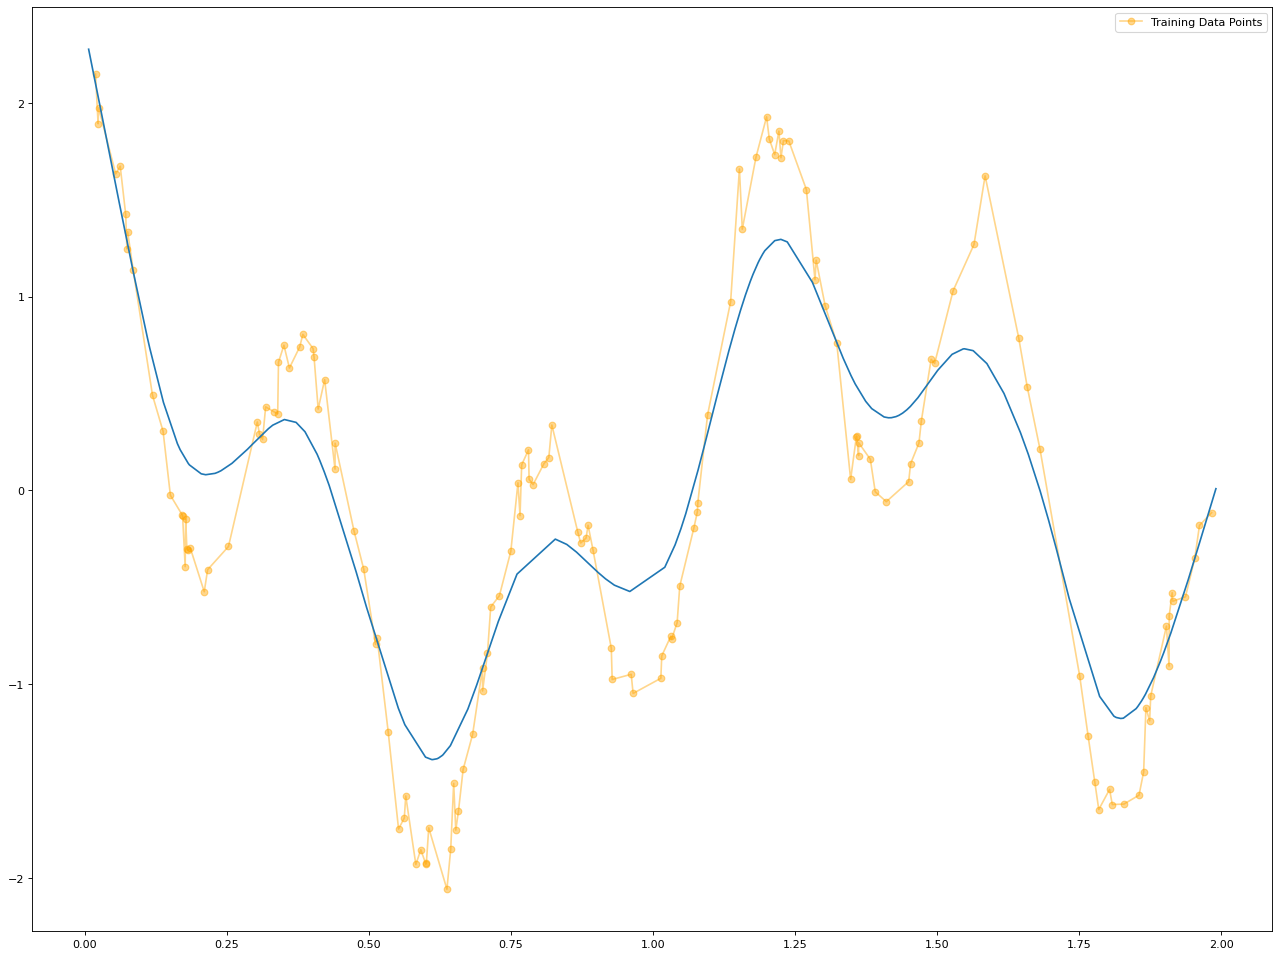

In [59]:
plotPredictions(X, y, numberSamples, tauList)

## Conclusion
- [ ] Find optimal value for `k`.
- [ ] Refactor code to show optimisation using elbow method.

# References
1. [Medium Article](https://towardsdatascience.com/locally-weighted-linear-regression-in-python-3d324108efbf)
2. [Creating Random Non-Linear Data](https://www.oreilly.com/library/view/effective-amazon-machine/9781785883231/586af32b-cd7f-40f4-bfe1-bea45b67a804.xhtml)